use lagged_choice_non_zero_1-6 => exclude brand lag non zero (IRA did it this way)

In [169]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

import optuna
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, brier_score_loss, confusion_matrix
from sklearn.model_selection import train_test_split, KFold

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from venn_abers import VennAbersCalibrator

In [170]:
# Read data
data = pd.read_excel("C:\\Users\\anjic\\Documents\\Logistics\\MARKETING\\data_purchase_wide_updated.xlsx")

# Remove specified columns
columns_to_remove = ["non_zero_brandlag", "NoIncome", "weekslast","trips", "lagged_choice_1", "lagged_choice_2", "lagged_choice_3", "lagged_choice_4", "lagged_choice_5","lagged_choice_6", "brandlag", 'sumvol', 'sumunits']
data = data.drop(columns=columns_to_remove)

# Adjust week numbers
data['week'] = data['week'] - 614  # gets weeks from 0 onwards, 614 min value
# Sorting weeks to do the 80/20 split
sorted_weeks = sorted(data['week'].unique())
train_ratio = 0.8
timing_train = int(train_ratio * len(sorted_weeks))
train_weeks = sorted_weeks[:timing_train]
test_weeks = sorted_weeks[timing_train:]

# Split data into training, calibration, and testing sets
train_data = data.loc[data['week'].isin(train_weeks)]
test_data = data.loc[data['week'].isin(test_weeks)]

x_train_venn = train_data.drop(columns=['brandbought', 'id', 'sumdollars' ])
y_train_venn = train_data['brandbought']


# Further split the training data into training and calibration sets
x_train_full, x_calib, y_train_full, y_calib = train_test_split(train_data.drop(columns=['brandbought', 'id', 'sumdollars']),
                                                                train_data['brandbought'],
                                                                test_size=0.25, #20% of total set is calibration set as 0.8*0.25
                                                                random_state=123)

x_test, y_test = test_data.drop(columns=['brandbought', 'id', 'sumdollars']), test_data['brandbought']

Random Forest

In [171]:
# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Create the model with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=123
    )

    # Train the model
    model.fit(x_train_full, y_train_full)
    
    # Make predictions
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)
    
    # Calculate F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy_score(y_test, y_pred)


# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

# Train the final model using the best hyperparameters
best_params = study.best_params
model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    random_state=123
)
model.fit(x_train_full, y_train_full)

[I 2024-06-17 08:19:59,166] A new study created in memory with name: no-name-34e0d9d5-964c-4bde-94eb-6adb8ec32e3d
[I 2024-06-17 08:20:01,246] Trial 0 finished with value: 0.5184049079754601 and parameters: {'n_estimators': 112, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5184049079754601.
[I 2024-06-17 08:20:02,203] Trial 1 finished with value: 0.5132924335378323 and parameters: {'n_estimators': 68, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5184049079754601.
[I 2024-06-17 08:20:04,412] Trial 2 finished with value: 0.5224948875255624 and parameters: {'n_estimators': 155, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 2 with value: 0.5224948875255624.
[I 2024-06-17 08:20:05,755] Trial 3 finished with value: 0.5276073619631901 and parameters: {'n_estimators': 108, 'max_depth': 14, 'min_

Best hyperparameters:  {'n_estimators': 91, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'entropy'}
Best accuracy:  0.5357873210633947


RandomForestClassifier(criterion='entropy', max_depth=28, min_samples_leaf=2,
                       min_samples_split=9, n_estimators=91, random_state=123)

feature importance for random forest (can be added to other models as well)

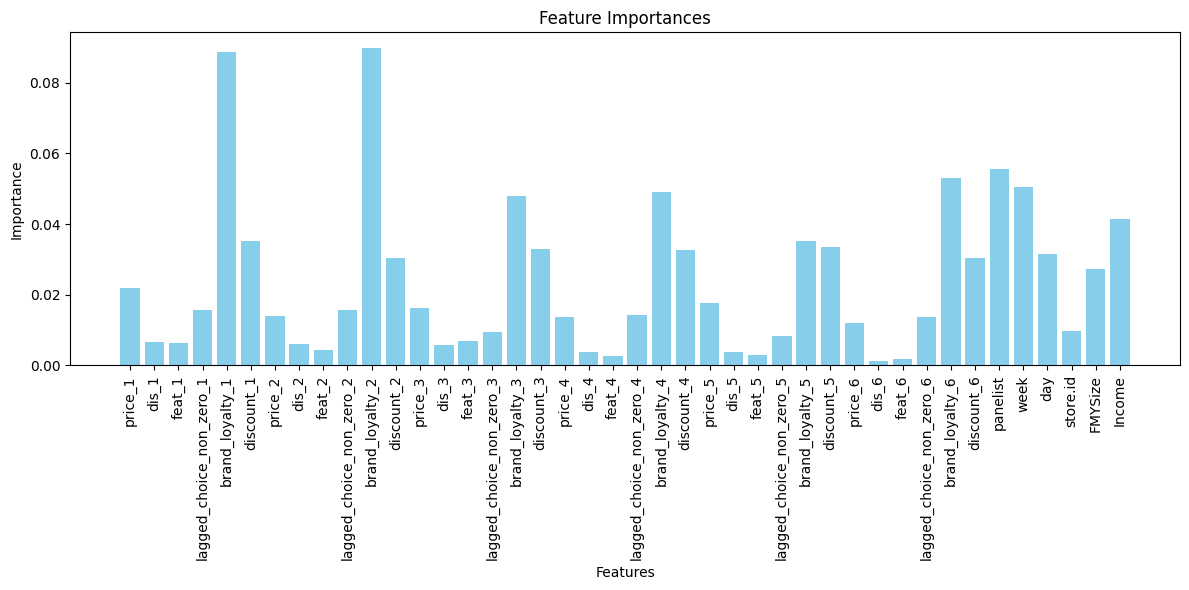

In [172]:
feature_importances = model.feature_importances_   
feature_names = x_train_full.columns

plt.figure(figsize=(12, 6))
plt.bar(feature_names, feature_importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()       # Adjust layout to make room for the labels
plt.show()

Calibration Random Forest with isotonic regression and venn predictor

In [173]:
# Make predictions with the original model
y_pred_original = model.predict(x_test)
y_pred_proba_original = model.predict_proba(x_test)

# Evaluate the original model
print("Original Model Results")
print("F1-score: ", f1_score(y_test, y_pred_original, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_original, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_original))

# Calculate the Brier score for each class and average them
brier_scores_original = []
for i in range(y_pred_proba_original.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_original[:, i])
    brier_scores_original.append(brier_score)

average_brier_score_original = sum(brier_scores_original) / len(brier_scores_original)
print("Average Brier Score: ", average_brier_score_original)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_original)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Calibrate the model using isotonic regression
calibrated = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
calibrated.fit(x_calib, y_calib)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Isotonic Model Results")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)


Original Model Results
F1-score:  0.5067022328154152
ROC-AUC:  0.7957161333150333
Accuracy:  0.5357873210633947
Average Brier Score:  0.16499689902504527
Confusion Matrix:
[[173 122   7   5   4   6]
 [ 70 271   8  10   3  11]
 [ 39  58  17   3   5   2]
 [ 24  44   2  15   2   3]
 [  5   7   0   1  12   0]
 [  2  10   0   1   0  36]]
Calibrated Isotonic Model Results
F1-score:  0.502805215722726
ROC-AUC:  0.78808400777178
Accuracy:  0.5276073619631901
Average Brier Score:  0.1660981361046956
Confusion Matrix:
[[136 152  17   5   4   3]
 [ 50 290  13   9   4   7]
 [ 25  62  25   6   5   1]
 [ 16  47   5  18   2   2]
 [  2  11   0   0  12   0]
 [  2  11   0   1   0  35]]


In [174]:
# Calibrate the model using the venn predictor
calibrated = VennAbersCalibrator(model, inductive=True, cal_size=0.25)
calibrated.fit(x_train_venn, y_train_venn)

# Make predictions with the calibrated model
y_pred_calib_proba = calibrated.predict_proba(x_test)

# Convert probabilities to class labels
y_pred_calib = y_pred_calib_proba.argmax(axis=1)

# Evaluate the calibrated model
print("Calibrated Venn Predictor Model Results")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_calib_proba, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_calib_proba.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_calib_proba[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_calib = confusion_matrix(y_test, y_pred_calib, labels=sorted(y_train_venn.unique()))
print("Confusion Matrix:")
print(conf_matrix_calib)

Calibrated Venn Predictor Model Results
F1-score:  0.14003080408332988
ROC-AUC:  0.7962762611395982
Accuracy:  0.16973415132924335
Average Brier Score:  0.1563483389411661
Confusion Matrix:
[[149   8  10   0   3   0]
 [277  10  16   3   9   0]
 [ 64  14   6   0   2   0]
 [ 42   2  24   1   2   0]
 [ 10   1   2   9   0   0]
 [  9   1   1   0  36   0]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


XGBoost

In [175]:
#since can calibrate only when values start with 0
y_train_full = y_train_full - 1
y_test  = y_test - 1
y_calib = y_calib -1 

In [176]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = XGBClassifier(**param, objective='multi:softprob', random_state=123)

    # Train the model
    model.fit(x_train_full, y_train_full)
    
    # Make predictions
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

# Train the final model using the best hyperparameters
best_params = study.best_params
xgb_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    objective='multi:softprob',
    random_state=123
)
xgb_model.fit(x_train_full, y_train_full)

# Make predictions with the original XGBoost model
y_pred_xgb_original = xgb_model.predict(x_test)
y_pred_proba_xgb_original = xgb_model.predict_proba(x_test)

# Evaluate the original XGBoost model
print("Original XGBoost Model Results")
print("F1-score: ", f1_score(y_test, y_pred_xgb_original, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_xgb_original, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb_original))

# Calculate the Brier score for each class and average them
brier_scores_xgb_original = []
for i in range(y_pred_proba_xgb_original.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_xgb_original[:, i])
    brier_scores_xgb_original.append(brier_score)

average_brier_score_xgb_original = sum(brier_scores_xgb_original) / len(brier_scores_xgb_original)
print("Average Brier Score: ", average_brier_score_xgb_original)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_xgb_original)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Calibrate the XGBoost model using the calibration set
calibrated_xgb = CalibratedClassifierCV(xgb_model, method="isotonic", cv="prefit")
calibrated_xgb.fit(x_calib, y_calib)

# Make predictions with the calibrated XGBoost model
y_pred_xgb_calib = calibrated_xgb.predict(x_test)
y_pred_proba_xgb_calib = calibrated_xgb.predict_proba(x_test)

# Evaluate the calibrated XGBoost model
print("Calibrated XGBoost Model Results with isotonic regression")
print("F1-score: ", f1_score(y_test, y_pred_xgb_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_xgb_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb_calib))

# Calculate the Brier score for each class and average them
brier_scores_xgb_calib = []
for i in range(y_pred_proba_xgb_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_xgb_calib[:, i])
    brier_scores_xgb_calib.append(brier_score)

average_brier_score_xgb_calib = sum(brier_scores_xgb_calib) / len(brier_scores_xgb_calib)
print("Average Brier Score: ", average_brier_score_xgb_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_xgb_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)



[I 2024-06-17 08:21:25,095] A new study created in memory with name: no-name-ec9f15ee-468b-4f70-9db2-8cd2db29d803
[I 2024-06-17 08:21:25,883] Trial 0 finished with value: 0.50920245398773 and parameters: {'n_estimators': 166, 'max_depth': 3, 'learning_rate': 0.13287742113359374, 'subsample': 0.5401292146310837, 'colsample_bytree': 0.6061385789459852, 'gamma': 0.4431048976576296, 'min_child_weight': 3}. Best is trial 0 with value: 0.50920245398773.
[I 2024-06-17 08:21:26,414] Trial 1 finished with value: 0.5061349693251533 and parameters: {'n_estimators': 83, 'max_depth': 8, 'learning_rate': 0.24679557901980148, 'subsample': 0.7097129492376755, 'colsample_bytree': 0.9705794638652119, 'gamma': 1.9471139885399764, 'min_child_weight': 2}. Best is trial 0 with value: 0.50920245398773.
[I 2024-06-17 08:21:28,781] Trial 2 finished with value: 0.5030674846625767 and parameters: {'n_estimators': 182, 'max_depth': 6, 'learning_rate': 0.24898018483701193, 'subsample': 0.8369141737439609, 'colsamp

Best hyperparameters:  {'n_estimators': 194, 'max_depth': 8, 'learning_rate': 0.16765797997353524, 'subsample': 0.9337762576033268, 'colsample_bytree': 0.6249219560437649, 'gamma': 3.618482364171866, 'min_child_weight': 10}
Best accuracy:  0.5388548057259713
Original XGBoost Model Results
F1-score:  0.5241739453365469
ROC-AUC:  0.8013188949377624
Accuracy:  0.5388548057259713
Average Brier Score:  0.09856166398456213
Confusion Matrix:
[[178 110  15  11   0   3]
 [ 75 251  16  16   4  11]
 [ 41  45  30   2   2   4]
 [ 24  34   7  22   0   3]
 [  4   9   1   2   9   0]
 [  2   8   1   1   0  37]]
Calibrated XGBoost Model Results with isotonic regression
F1-score:  0.5081188368542232
ROC-AUC:  0.8011650522257909
Accuracy:  0.5245398773006135
Average Brier Score:  0.09910077091130269
Confusion Matrix:
[[162 122  18  11   1   3]
 [ 73 258  18  11   4   9]
 [ 38  52  28   3   1   2]
 [ 19  40   9  19   0   3]
 [  3   9   1   2  10   0]
 [  2   9   1   1   0  36]]


In [177]:
# Calibrate the model using the venn predictor
calibrated = VennAbersCalibrator(model, inductive=True, cal_size=0.25)
calibrated.fit(x_train_venn, y_train_venn)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)[:,1]
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results with Venn Predictor")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


Calibrated Model Results with Venn Predictor
F1-score:  0.38599776714192224
ROC-AUC:  0.7991877828015278
Accuracy:  0.4611451942740286
Average Brier Score:  0.10027257302107807
Confusion Matrix:
[[214 103   0   0   0   0]
 [136 237   0   0   0   0]
 [ 83  41   0   0   0   0]
 [ 63  27   0   0   0   0]
 [ 16   9   0   0   0   0]
 [ 41   8   0   0   0   0]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


AdaBoost

In [178]:
from sklearn.ensemble import AdaBoostClassifier

# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0)
    }

    model = AdaBoostClassifier(**param, random_state=123)

    # Train the model
    model.fit(x_train_full, y_train_full)
    
    # Make predictions
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

# Train the final model using the best hyperparameters
best_params = study.best_params
ada_model = AdaBoostClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=123
)
ada_model.fit(x_train_full, y_train_full)

# Make predictions with the original AdaBoost model
y_pred_ada_original = ada_model.predict(x_test)
y_pred_proba_ada_original = ada_model.predict_proba(x_test)

# Evaluate the original AdaBoost model
print("Original AdaBoost Model Results")
print("F1-score: ", f1_score(y_test, y_pred_ada_original, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_ada_original, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_ada_original))

# Calculate the Brier score for each class and average them
brier_scores_ada_original = []
for i in range(y_pred_proba_ada_original.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_ada_original[:, i])
    brier_scores_ada_original.append(brier_score)

average_brier_score_ada_original = sum(brier_scores_ada_original) / len(brier_scores_ada_original)
print("Average Brier Score: ", average_brier_score_ada_original)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_ada_original)
print("Confusion Matrix:")
print(conf_matrix_rf)


# Calibrate the AdaBoost model using the calibration set
calibrated_ada = CalibratedClassifierCV(ada_model, method="isotonic", cv="prefit")
calibrated_ada.fit(x_calib, y_calib)

# Make predictions with the calibrated AdaBoost model
y_pred_ada_calib = calibrated_ada.predict(x_test)
y_pred_proba_ada_calib = calibrated_ada.predict_proba(x_test)

# Evaluate the calibrated AdaBoost model
print("Calibrated AdaBoost Model Results with Isotonic Regression")
print("F1-score: ", f1_score(y_test, y_pred_ada_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_ada_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_ada_calib))

# Calculate the Brier score for each class and average them
brier_scores_ada_calib = []
for i in range(y_pred_proba_ada_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_ada_calib[:, i])
    brier_scores_ada_calib.append(brier_score)

average_brier_score_ada_calib = sum(brier_scores_ada_calib) / len(brier_scores_ada_calib)
print("Average Brier Score: ", average_brier_score_ada_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_ada_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Calibrate the model using the venn predictor
calibrated = VennAbersCalibrator(model, inductive=True, cal_size=0.25)
calibrated.fit(x_train_venn, y_train_venn)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)[:,1]
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results with Venn Predictor")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)


[I 2024-06-17 08:22:21,125] A new study created in memory with name: no-name-fa7c93ff-a645-4d8f-a18d-a33c71050041
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2024-06-17 08:22:22,018] Trial 0 finished with value: 0.5122699386503068 and parameters: {'n_estimators': 67, 'learning_rate': 0.4463328170232282}. Best is trial 0 with value: 0.5122699386503068.
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2024-06-17 08:22:22,854] Trial 1 finished with value: 0.5153374233128835 and parameters: {'n_estimators': 63, 'learning_rate': 0.561445063

Best hyperparameters:  {'n_estimators': 163, 'learning_rate': 0.17248412373554334}
Best accuracy:  0.5276073619631901
Original AdaBoost Model Results
F1-score:  0.4953848371304025
ROC-AUC:  0.7507837189747502
Accuracy:  0.5276073619631901
Average Brier Score:  0.13497258660612912
Confusion Matrix:
[[174 132   3   3   1   4]
 [ 77 269   9   9   3   6]
 [ 43  60  14   2   4   1]
 [ 31  39   5  13   0   2]
 [  3  12   0   1   9   0]
 [  2   7   1   1   1  37]]
Calibrated AdaBoost Model Results with Isotonic Regression
F1-score:  0.4406982291884932
ROC-AUC:  0.7751869855106103
Accuracy:  0.5
Average Brier Score:  0.10636064029664027
Confusion Matrix:
[[148 166   0   0   0   3]
 [ 68 296   2   1   2   4]
 [ 35  83   4   0   1   1]
 [ 22  62   0   1   3   2]
 [  2  15   0   0   8   0]
 [  0  17   0   0   0  32]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


Calibrated Model Results with Venn Predictor
F1-score:  0.38804328910118624
ROC-AUC:  0.7942991597710981
Accuracy:  0.46830265848670755
Average Brier Score:  0.10135941947583298
Confusion Matrix:
[[179 138   0   0   0   0]
 [ 94 279   0   0   0   0]
 [ 75  49   0   0   0   0]
 [ 53  37   0   0   0   0]
 [ 17   8   0   0   0   0]
 [ 40   9   0   0   0   0]]


In [179]:
# Calibrate the model using the venn predictor
calibrated = VennAbersCalibrator(model, inductive=True, cal_size=0.25)
calibrated.fit(x_train_venn, y_train_venn)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)[:,1]
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results with Venn Predictor")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)

average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_calib)
print("Confusion Matrix:")
print(conf_matrix_rf)


Calibrated Model Results with Venn Predictor
F1-score:  0.3855872075999326
ROC-AUC:  0.7951191562796104
Accuracy:  0.46421267893660534
Average Brier Score:  0.1007992649811875
Confusion Matrix:
[[189 128   0   0   0   0]
 [108 265   0   0   0   0]
 [ 69  55   0   0   0   0]
 [ 55  35   0   0   0   0]
 [ 15  10   0   0   0   0]
 [ 41   8   0   0   0   0]]


5-fold cross validation with isotonic regression first, afterwards with venn predictor

Random forest + isotonic regression

In [193]:
from sklearn.model_selection import TimeSeriesSplit
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
        
rf = RandomForestClassifier()
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_full)

CalibratedClassifierCV(cv=<generator object time_dependent_k_fold_split at 0x000001DD606062F0>,
                       estimator=RandomForestClassifier(), method='isotonic')

In [194]:
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
        
rf = RandomForestClassifier()
rf.fit(x_train_full, y_train_full)
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_full)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)
    
average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)


Calibrated Model Results
F1-score:  0.48278951434577005
ROC-AUC:  0.7796590227273862
Accuracy:  0.5204498977505112
Average Brier Score:  0.10294340996130301


In [183]:
# Print confusion matrices for each fold
fold = 1
for train_index, test_index in time_dependent_k_fold_split(x_train_full, y_train_full, 5):
    X_train_fold, X_test_fold = x_train_full.iloc[train_index], x_train_full.iloc[test_index]
    y_train_fold, y_test_fold = y_train_full.iloc[train_index], y_train_full.iloc[test_index]
    
    rf_fold = RandomForestClassifier()
    rf_fold.fit(X_train_fold, y_train_fold)
    
    calibrated_fold = CalibratedClassifierCV(rf_fold, method='isotonic', cv='prefit')
    calibrated_fold.fit(X_test_fold, y_test_fold)
    
    y_pred_fold = calibrated_fold.predict(X_test_fold)
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    
    print(f"Confusion Matrix for Fold {fold}:")
    print(cm)
    fold += 1
    

Confusion Matrix for Fold 1:
[[ 79  71   0   0   0   1]
 [ 43 161   5   3   2   3]
 [ 10  25   5   0   1   2]
 [ 15  16   1   7   2   1]
 [  6  12   0   0   3   0]
 [  8   7   1   0   1  11]]
Confusion Matrix for Fold 2:
[[ 89  62   1   3   2   0]
 [ 37 155   1   7   1   0]
 [ 17  26   6   2   0   0]
 [ 13  27   2   9   2   0]
 [  2  12   0   3   4   0]
 [  3   5   0   3   0   8]]
Confusion Matrix for Fold 3:
[[ 66  82   2   0   0   0]
 [ 45 172   1   2   1   0]
 [ 19  28   7   0   0   2]
 [ 12  19   0   3   0   0]
 [  5   9   0   0   5   0]
 [  1   8   3   0   1   9]]
Confusion Matrix for Fold 4:
[[102  52   1   4   1   0]
 [ 42 136   3   8   0   4]
 [ 20  17   9   5   1   0]
 [ 14  14   3  26   1   0]
 [  6   9   0   2   6   0]
 [  2   4   0   0   2   8]]
Confusion Matrix for Fold 5:
[[ 73  72   3   3   0   1]
 [ 27 187   4   1   1   1]
 [ 10  31  13   0   0   1]
 [  7  27   2   6   0   0]
 [  2  11   0   0   1   0]
 [  2   8   1   0   0   7]]


Random forest + venn predictor 

In [184]:
from sklearn.naive_bayes import LabelBinarizer
# Custom time-dependent k-fold split function
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index

# Perform time-dependent k-fold cross-validation
metrics = {'accuracy': [], 'f1': [], 'roc_auc': [], 'brier_score': []}
confusion_matrices = []

# Initialize an empty list to store the predictions
p_pred_list = []

for train_index, cal_index in time_dependent_k_fold_split(x_train_full, y_train_full, n_splits=5):
    X_tr, X_cal = x_train_full.iloc[train_index], x_train_full.iloc[cal_index]
    y_tr, y_cal = y_train_full.iloc[train_index], y_train_full.iloc[cal_index]
    
    rf = RandomForestClassifier()
    rf.fit(X_tr, y_tr)
    
    p_cal = rf.predict_proba(X_cal)
    p_test = rf.predict_proba(x_test)
    
    va = VennAbersCalibrator()
    p_pred = va.predict_proba(p_cal=p_cal, y_cal=y_cal.to_numpy(), p_test=p_test, p0_p1_output=False)
    
    p_pred_list.append(p_pred)
    
    y_pred = np.argmax(p_pred, axis=1)
    
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        
    if len(np.unique(y_train_full)) > 2:  # Multi-class case
        lb = LabelBinarizer()
        y_test_binarized = lb.fit_transform(y_test)
        roc_auc = roc_auc_score(y_test_binarized, p_pred, multi_class='ovr')
        
        # Calculate Brier score for each class and average them
        brier_scores = []
        for i in range(p_pred.shape[1]):
            brier_score = brier_score_loss(y_test_binarized[:, i], p_pred[:, i])
            brier_scores.append(brier_score)
        average_brier_score = np.mean(brier_scores)
    else:  # Binary case
        roc_auc = roc_auc_score(y_test, p_pred[:, 1])
        average_brier_score = brier_score_loss(y_test, p_pred[:, 1])
    
    metrics['roc_auc'].append(roc_auc)
    metrics['brier_score'].append(average_brier_score)
    
    # Calculate and store the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

# Average over all p_pred
average_p_pred = np.mean(p_pred_list, axis=0)

# Evaluate and Print Cross-Validation Results
print("Time-Series Cross-Validation Results for Venn Classifier:")
print(f"Accuracy: {np.mean(metrics['accuracy'])} ± {np.std(metrics['accuracy'])}")
print(f"F1 Score: {np.mean(metrics['f1'])} ± {np.std(metrics['f1'])}")
print(f"ROC AUC: {np.mean(metrics['roc_auc'])} ± {np.std(metrics['roc_auc'])}")
print(f"Brier Score Loss: {np.mean(metrics['brier_score'])} ± {np.std(metrics['brier_score'])}")

# Print confusion matrices for each fold
for i, conf_matrix in enumerate(confusion_matrices):
    print(f"Confusion Matrix for fold {i + 1}:")
    print(conf_matrix)

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


Time-Series Cross-Validation Results for Venn Classifier:
Accuracy: 0.492638036809816 ± 0.01486526122321984
F1 Score: 0.4484814547440766 ± 0.022722419329497305
ROC AUC: 0.7644518268513525 ± 0.008543137458097384
Brier Score Loss: 0.1064517599763789 ± 0.001376525128398933
Confusion Matrix for fold 1:
[[104 208   0   0   1   4]
 [ 48 318   0   0   1   6]
 [ 23  98   1   0   0   2]
 [ 27  61   0   1   0   1]
 [  4  13   0   0   8   0]
 [  3  10   0   0   0  36]]
Confusion Matrix for fold 2:
[[155 141   6  12   1   2]
 [ 80 245  15  30   0   3]
 [ 39  62  15   7   0   1]
 [ 26  37   6  20   0   1]
 [  4  10   0  10   1   0]
 [ 11   8   1   1   0  28]]
Confusion Matrix for fold 3:
[[133 175   3   1   3   2]
 [ 48 307   7   3   5   3]
 [ 29  77  10   0   7   1]
 [ 22  58   1   5   3   1]
 [  4   7   0   0  14   0]
 [  2  11   0   0   1  35]]
Confusion Matrix for fold 4:
[[169 133   6   7   0   2]
 [ 91 251  14  12   2   3]
 [ 44  59  16   2   2   1]
 [ 27  47   2  12   1   1]
 [  4   9   1   

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


XGBoost + isotonic


In [185]:
from sklearn.model_selection import TimeSeriesSplit

# Ensure target labels are zero-based
y_train_zero_based = y_train_full - y_train_full.min()
y_test_zero_based = y_test - y_train_full.min()

def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
rf = XGBClassifier()
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_zero_based)

CalibratedClassifierCV(cv=<generator object time_dependent_k_fold_split at 0x000001DD606056C0>,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=N...
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...),
                       method='isotonic')

In [186]:
# Evaluate the model
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, brier_score_loss

y_pred_calib = calibrated.predict(x_test)
y_pred_proba_calib = calibrated.predict_proba(x_test)

print("Calibrated Model Results")
print("F1-score: ", f1_score(y_test_zero_based, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test_zero_based, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test_zero_based, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = [brier_score_loss((y_test_zero_based == i).astype(int), y_pred_proba_calib[:, i]) for i in range(y_pred_proba_calib.shape[1])]
average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

Calibrated Model Results
F1-score:  0.46771219562041794
ROC-AUC:  0.7760947641434369
Accuracy:  0.5061349693251533
Average Brier Score:  0.10360653231404743


In [187]:
# Print confusion matrices for each fold
fold = 1
for train_index, test_index in time_dependent_k_fold_split(x_train_full, y_train_full, 5):
    X_train_fold, X_test_fold = x_train_full.iloc[train_index], x_train_full.iloc[test_index]
    y_train_fold, y_test_fold = y_train_full.iloc[train_index], y_train_full.iloc[test_index]
    
    rf_fold = XGBClassifier()
    rf_fold.fit(X_train_fold, y_train_fold)
    
    calibrated_fold = CalibratedClassifierCV(rf_fold, method='isotonic', cv='prefit')
    calibrated_fold.fit(X_test_fold, y_test_fold)
    
    y_pred_fold = calibrated_fold.predict(X_test_fold)
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    
    print(f"Confusion Matrix for Fold {fold}:")
    print(cm)
    fold += 1
    

Confusion Matrix for Fold 1:
[[ 66  84   0   1   0   0]
 [ 37 175   2   2   0   1]
 [ 12  28   1   0   1   1]
 [ 12  22   0   7   1   0]
 [  7   9   0   0   4   1]
 [  7   8   0   0   2  11]]
Confusion Matrix for Fold 2:
[[ 94  58   0   5   0   0]
 [ 54 144   0   1   2   0]
 [ 23  21   5   0   0   2]
 [ 13  30   1   7   2   0]
 [  2  11   1   1   6   0]
 [  5   4   0   3   0   7]]
Confusion Matrix for Fold 3:
[[ 60  87   2   1   0   0]
 [ 37 170   1   5   2   6]
 [ 17  28   7   0   1   3]
 [  8  16   1   7   0   2]
 [  3   6   0   2   7   1]
 [  2   3   3   0   0  14]]
Confusion Matrix for Fold 4:
[[ 98  57   0   4   1   0]
 [ 39 137   3   7   2   5]
 [ 17  20   8   5   1   1]
 [ 16  16   3  21   1   1]
 [  7  10   0   0   5   1]
 [  1   3   1   1   2   8]]
Confusion Matrix for Fold 5:
[[ 85  52   8   6   0   1]
 [ 42 170   6   2   0   1]
 [ 17  25  13   0   0   0]
 [  8  21   4   9   0   0]
 [  2  12   0   0   0   0]
 [  3   7   0   0   0   8]]


venn predictor + XGBoost + 5-fold-cross validation

In [188]:
from sklearn.naive_bayes import LabelBinarizer
# Custom time-dependent k-fold split function
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index

# Perform time-dependent k-fold cross-validation
metrics = {'accuracy': [], 'f1': [], 'roc_auc': [], 'brier_score': []}
confusion_matrices = []

# Initialize an empty list to store the predictions
p_pred_list = []

for train_index, cal_index in time_dependent_k_fold_split(x_train_full, y_train_full, n_splits=5):
    X_tr, X_cal = x_train_full.iloc[train_index], x_train_full.iloc[cal_index]
    y_tr, y_cal = y_train_full.iloc[train_index], y_train_full.iloc[cal_index]
    
    rf = XGBClassifier()
    rf.fit(X_tr, y_tr)
    
    p_cal = rf.predict_proba(X_cal)
    p_test = rf.predict_proba(x_test)
    
    va = VennAbersCalibrator()
    p_pred = va.predict_proba(p_cal=p_cal, y_cal=y_cal.to_numpy(), p_test=p_test, p0_p1_output=False)
    
    p_pred_list.append(p_pred)
    
    y_pred = np.argmax(p_pred, axis=1)
    
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        
    if len(np.unique(y_train_full)) > 2:  # Multi-class case
        lb = LabelBinarizer()
        y_test_binarized = lb.fit_transform(y_test)
        roc_auc = roc_auc_score(y_test_binarized, p_pred, multi_class='ovr')
        
        # Calculate Brier score for each class and average them
        brier_scores = []
        for i in range(p_pred.shape[1]):
            brier_score = brier_score_loss(y_test_binarized[:, i], p_pred[:, i])
            brier_scores.append(brier_score)
        average_brier_score = np.mean(brier_scores)
    else:  # Binary case
        roc_auc = roc_auc_score(y_test, p_pred[:, 1])
        average_brier_score = brier_score_loss(y_test, p_pred[:, 1])
    
    metrics['roc_auc'].append(roc_auc)
    metrics['brier_score'].append(average_brier_score)
    
    # Calculate and store the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

# Average over all p_pred
average_p_pred = np.mean(p_pred_list, axis=0)

# Evaluate and Print Cross-Validation Results
print("Time-Series Cross-Validation Results for Venn Classifier:")
print(f"Accuracy: {np.mean(metrics['accuracy'])} ± {np.std(metrics['accuracy'])}")
print(f"F1 Score: {np.mean(metrics['f1'])} ± {np.std(metrics['f1'])}")
print(f"ROC AUC: {np.mean(metrics['roc_auc'])} ± {np.std(metrics['roc_auc'])}")
print(f"Brier Score Loss: {np.mean(metrics['brier_score'])} ± {np.std(metrics['brier_score'])}")

# Print confusion matrices for each fold
for i, conf_matrix in enumerate(confusion_matrices):
    print(f"Confusion Matrix for fold {i + 1}:")
    print(conf_matrix)

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


Time-Series Cross-Validation Results for Venn Classifier:
Accuracy: 0.48957055214723927 ± 0.015566120436797606
F1 Score: 0.4494324682696888 ± 0.031869362767664645
ROC AUC: 0.7534643489524359 ± 0.012359904754717762
Brier Score Loss: 0.10813380914280282 ± 0.002391433150231952
Confusion Matrix for fold 1:
[[ 62 243   2   4   4   2]
 [ 21 331   2  10   5   4]
 [ 10 105   3   3   0   3]
 [ 11  64   0  12   2   1]
 [  1  11   0   1  11   1]
 [  2  13   0   0   0  34]]
Confusion Matrix for fold 2:
[[186 118   0   6   4   3]
 [112 237   1  16   3   4]
 [ 54  54   8   5   1   2]
 [ 34  38   2  13   2   1]
 [  5  10   0   8   2   0]
 [ 14   6   0   3   1  25]]
Confusion Matrix for fold 3:
[[141 154   8   3   5   6]
 [ 68 275  10   7   7   6]
 [ 29  66  16   5   6   2]
 [ 31  39   4   8   5   3]
 [  5   7   0   0  13   0]
 [  5  10   0   1   0  33]]
Confusion Matrix for fold 4:
[[166 121   5  15   7   3]
 [ 85 250  11  13   8   6]
 [ 39  60  13   4   6   2]
 [ 40  29   2  15   2   2]
 [  3   7   

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


AdaBoost

In [195]:
from sklearn.model_selection import TimeSeriesSplit
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
rf = AdaBoostClassifier(algorithm='SAMME')
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_full)
p_test_calibrated = calibrated.predict_proba(x_test)

In [196]:
from sklearn.model_selection import TimeSeriesSplit
rf = AdaBoostClassifier(algorithm='SAMME')
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index
rf.fit(x_train_full, y_train_full)
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=time_dependent_k_fold_split(x_train_full, y_train_full, 5))
calibrated.fit(x_train_full, y_train_full)

# Make predictions with the calibrated model
y_pred_calib = calibrated.predict(x_test)
y_pred_proba_calib = calibrated.predict_proba(x_test)

# Evaluate the calibrated model
print("Calibrated Model Results")
print("F1-score: ", f1_score(y_test, y_pred_calib, average='weighted'))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba_calib, multi_class='ovr'))
print("Accuracy: ", accuracy_score(y_test, y_pred_calib))

# Calculate the Brier score for each class and average them
brier_scores_calib = []
for i in range(y_pred_proba_calib.shape[1]):
    brier_score = brier_score_loss((y_test == i).astype(int), y_pred_proba_calib[:, i])
    brier_scores_calib.append(brier_score)
    
average_brier_score_calib = sum(brier_scores_calib) / len(brier_scores_calib)
print("Average Brier Score: ", average_brier_score_calib)

Calibrated Model Results
F1-score:  0.47532683176409474
ROC-AUC:  0.7856771274865147
Accuracy:  0.49897750511247446
Average Brier Score:  0.10291837065278105


In [197]:
# Print confusion matrices for each fold
fold = 1
for train_index, test_index in time_dependent_k_fold_split(x_train_full, y_train_full, 5):
    X_train_fold, X_test_fold = x_train_full.iloc[train_index], x_train_full.iloc[test_index]
    y_train_fold, y_test_fold = y_train_full.iloc[train_index], y_train_full.iloc[test_index]
    
    rf_fold = AdaBoostClassifier()
    rf_fold.fit(X_train_fold, y_train_fold)
    
    calibrated_fold = CalibratedClassifierCV(rf_fold, method='isotonic', cv='prefit')
    calibrated_fold.fit(X_test_fold, y_test_fold)
    
    y_pred_fold = calibrated_fold.predict(X_test_fold)
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    
    print(f"Confusion Matrix for Fold {fold}:")
    print(cm)
    fold += 1

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 1:
[[  2 148   0   0   0   1]
 [  1 216   0   0   0   0]
 [  0  43   0   0   0   0]
 [  0  40   0   2   0   0]
 [  0  21   0   0   0   0]
 [  9  17   0   0   0   2]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 2:
[[ 75  82   0   0   0   0]
 [ 36 164   0   0   0   1]
 [ 20  31   0   0   0   0]
 [ 12  41   0   0   0   0]
 [  3  18   0   0   0   0]
 [  1   9   0   0   0   9]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 3:
[[ 19 130   0   0   1   0]
 [  8 212   0   0   0   1]
 [  4  50   0   0   0   2]
 [  1  32   0   0   1   0]
 [  3  10   0   0   4   2]
 [  2  14   0   0   0   6]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 4:
[[ 87  67   1   5   0   0]
 [ 34 154   0   2   3   0]
 [ 24  25   2   1   0   0]
 [ 19  29   2   6   2   0]
 [  4  13   0   0   6   0]
 [  1  12   1   0   0   2]]


c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix for Fold 5:
[[ 65  84   0   0   1   2]
 [ 17 202   0   0   1   1]
 [ 12  42   0   0   0   1]
 [ 13  27   0   0   1   1]
 [  5   9   0   0   0   0]
 [  1   9   0   0   0   8]]


venn predictor + AdaBoost + 5-fold-cross validation

In [198]:
from sklearn.naive_bayes import LabelBinarizer
# Custom time-dependent k-fold split function
def time_dependent_k_fold_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        yield train_index, test_index

# Perform time-dependent k-fold cross-validation
metrics = {'accuracy': [], 'f1': [], 'roc_auc': [], 'brier_score': []}
confusion_matrices = []

# Initialize an empty list to store the predictions
p_pred_list = []

for train_index, cal_index in time_dependent_k_fold_split(x_train_full, y_train_full, n_splits=5):
    X_tr, X_cal = x_train_full.iloc[train_index], x_train_full.iloc[cal_index]
    y_tr, y_cal = y_train_full.iloc[train_index], y_train_full.iloc[cal_index]
    
    rf = AdaBoostClassifier()
    rf.fit(X_tr, y_tr)
    
    p_cal = rf.predict_proba(X_cal)
    p_test = rf.predict_proba(x_test)
    
    va = VennAbersCalibrator()
    p_pred = va.predict_proba(p_cal=p_cal, y_cal=y_cal.to_numpy(), p_test=p_test, p0_p1_output=False)
    
    p_pred_list.append(p_pred)
    
    y_pred = np.argmax(p_pred, axis=1)
    
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        
    if len(np.unique(y_train_full)) > 2:  # Multi-class case
        lb = LabelBinarizer()
        y_test_binarized = lb.fit_transform(y_test)
        roc_auc = roc_auc_score(y_test_binarized, p_pred, multi_class='ovr')
        
        # Calculate Brier score for each class and average them
        brier_scores = []
        for i in range(p_pred.shape[1]):
            brier_score = brier_score_loss(y_test_binarized[:, i], p_pred[:, i])
            brier_scores.append(brier_score)
        average_brier_score = np.mean(brier_scores)
    else:  # Binary case
        roc_auc = roc_auc_score(y_test, p_pred[:, 1])
        average_brier_score = brier_score_loss(y_test, p_pred[:, 1])
    
    metrics['roc_auc'].append(roc_auc)
    metrics['brier_score'].append(average_brier_score)
    
    # Calculate and store the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

# Average over all p_pred
average_p_pred = np.mean(p_pred_list, axis=0)

# Evaluate and Print Cross-Validation Results
print("Time-Series Cross-Validation Results for Venn Classifier:")
print(f"Accuracy: {np.mean(metrics['accuracy'])} ± {np.std(metrics['accuracy'])}")
print(f"F1 Score: {np.mean(metrics['f1'])} ± {np.std(metrics['f1'])}")
print(f"ROC AUC: {np.mean(metrics['roc_auc'])} ± {np.std(metrics['roc_auc'])}")
print(f"Brier Score Loss: {np.mean(metrics['brier_score'])} ± {np.std(metrics['brier_score'])}")

# Print confusion matrices for each fold
for i, conf_matrix in enumerate(confusion_matrices):
    print(f"Confusion Matrix for fold {i + 1}:")
    print(conf_matrix)

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\sklearn\ens

Time-Series Cross-Validation Results for Venn Classifier:
Accuracy: 0.4419222903885481 ± 0.03220063523697912
F1 Score: 0.40859581797910083 ± 0.05025196428572967
ROC AUC: 0.7398859897997536 ± 0.02582985259102446
Brier Score Loss: 0.11245821725664959 ± 0.0046366274986638705
Confusion Matrix for fold 1:
[[ 68 245   4   0   0   0]
 [ 41 329   3   0   0   0]
 [  7 113   3   0   0   1]
 [  8  82   0   0   0   0]
 [  2  22   1   0   0   0]
 [ 34  10   2   0   0   3]]
Confusion Matrix for fold 2:
[[187 113   4  10   2   1]
 [123 214  22  10   3   1]
 [ 54  45  19   4   2   0]
 [ 45  23   7  13   2   0]
 [  4  12   1   2   6   0]
 [  6  23   7   0   0  13]]
Confusion Matrix for fold 3:
[[136  79  67  22  13   0]
 [ 93 173  76  22   9   0]
 [ 33  23  54   5   9   0]
 [ 19  18  36  12   5   0]
 [  2   3   5   3  12   0]
 [  8  24  15   1   1   0]]
Confusion Matrix for fold 4:
[[138 123  13  41   1   1]
 [ 62 222  23  60   5   1]
 [ 40  39  23  18   4   0]
 [ 23  18   7  42   0   0]
 [  4   6   0 

c:\Users\anjic\Documents\Logistics\MARKETING\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


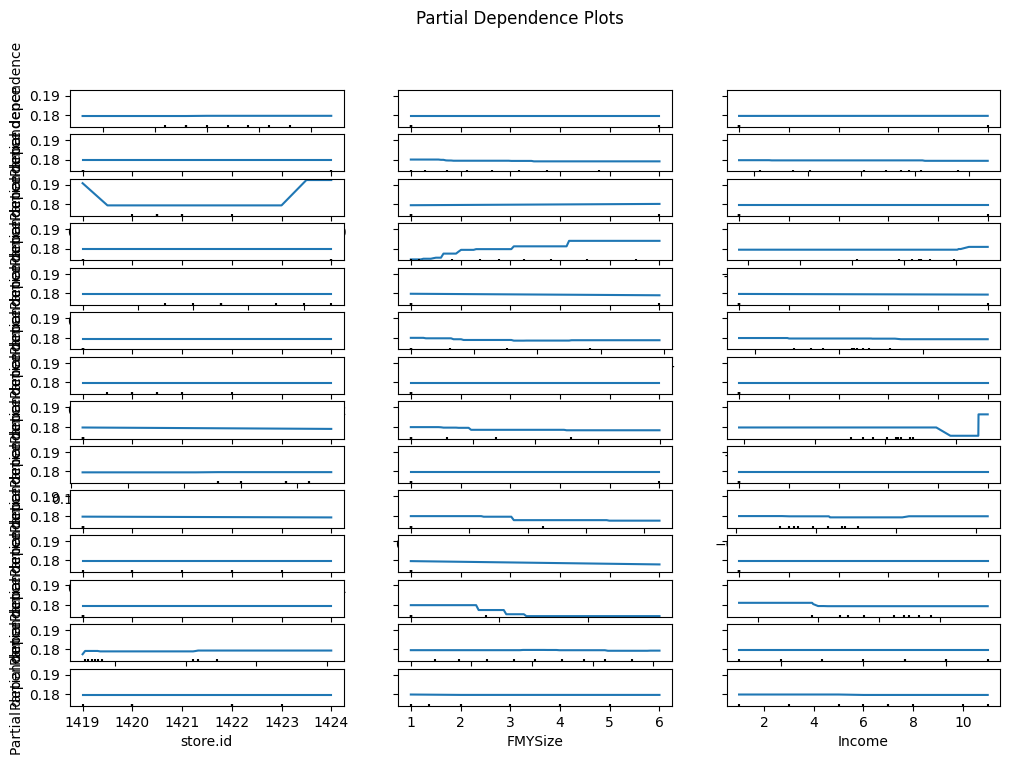

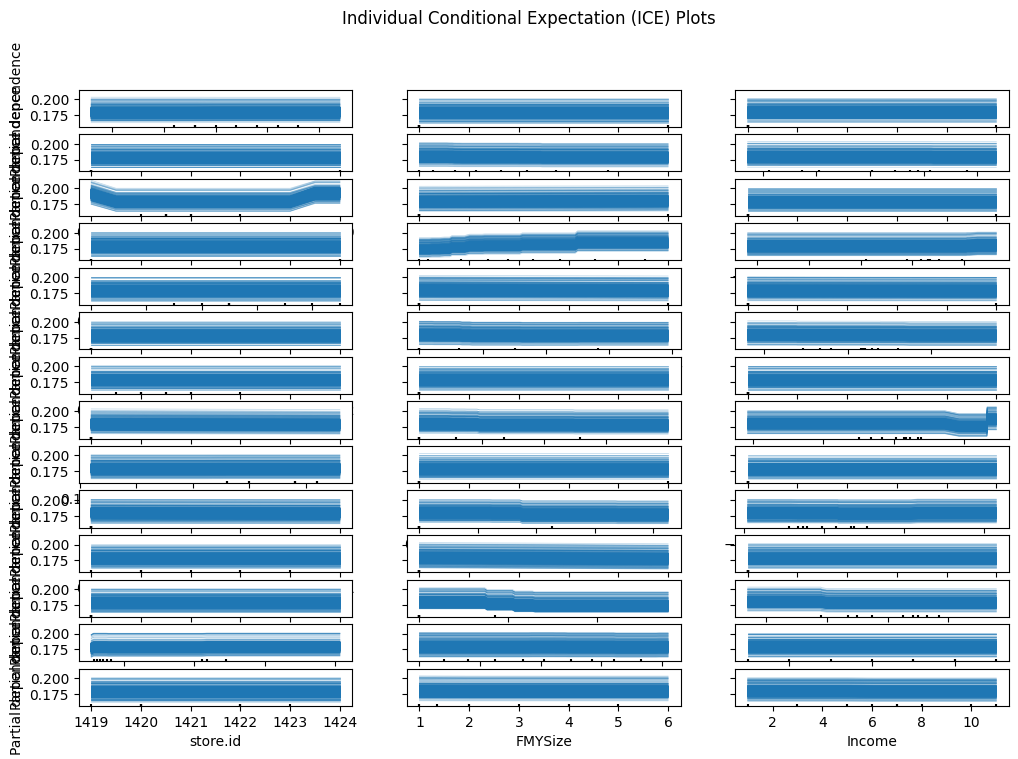

In [199]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming `ada_model` is your trained model and `x_train_full` is your training data
features = x_train_full.columns

# Define the target class for the partial dependence plots
target_class = 1 

# Plotting PDP
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(ada_model, x_train_full, features, ax=ax, target=target_class)
plt.suptitle('Partial Dependence Plots')
plt.show()

# Plotting ICE (Individual Conditional Expectation) plots
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(ada_model, x_train_full, features, kind='individual', ax=ax, target=target_class)
plt.suptitle('Individual Conditional Expectation (ICE) Plots')
plt.show()
